In [73]:
import os
import pandas as pd
import numpy as np

import zipfile
from urllib import request

def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [74]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [75]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [76]:
from torch import nn
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_users, num_hidden, bias = True),
            nn.Sigmoid(),
            # nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, num_users, bias=True),
            # nn.ReLU(True),
        )
        self.type = type

    def forward(self, input, type='train'):
        x = self.encoder(input)
        pred = self.decoder(x)
        if type == 'train':  # Mask the gradient during training
            return pred * torch.sign(input)
        else:
            return pred

In [77]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  """Entry point for launching an IPython kernel.


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [78]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the MovieLens 100K dataset
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = DataLoader(train_inter_mat, shuffle=True, batch_size=256)
test_iter = DataLoader(test_inter_mat, shuffle=True,batch_size=256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  


In [79]:
next(iter(train_iter)).shape

torch.Size([256, 943])

In [80]:
# Model initialization, training, and evaluation

# param 
lr, num_epoch, weight_decay, num_hidden = 0.002, 100, 1e-5, 500

net = AutoRec(num_hidden, num_users).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)

In [81]:
def evaluator(net, iter_matrix, device):
    loss = 0
    for i, values in enumerate(test_iter):
        x = values.to(device).float()
        output = net(x) #, type='test')
        loss += loss_func(output,x).cpu().detach().numpy()
    return loss/(i+1)

In [82]:
from tqdm import tqdm
train_arr, test_arr = [], []
for epoch in tqdm(range(num_epoch)):
    train_loss = 0
    test_loss = 0
    for i, x in enumerate(train_iter):
        x = x.to(device).float()
        # ===================forward=====================
        output = net.forward(x)
        loss = loss_func(output,x)
         # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # =================loss calculate==================
        train_loss += loss.cpu().detach().numpy()
    train_arr.append(train_loss/(i+1))
    test_arr.append(evaluator(net, test_iter, device))



100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


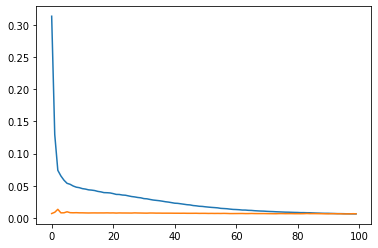

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_arr)
ax.plot(test_arr)
plt.show()